# Signate
# FDUA
# 第2回 金融データ活用チャレンジ

In [1]:
import os
import datetime
import random
import pandas as pd
import numpy as np

import datetime
from sklearn import model_selection
from sklearn.preprocessing import LabelEncoder
from category_encoders import CountEncoder
from sklearn.utils.class_weight import compute_sample_weight
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score

import lightgbm as lgb
#import optuna.integration.lightgbm as lgb

import seaborn as sns
#sns.set(font='Yu Gothic')

from matplotlib_venn import venn2
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
def seed_everything(seed: int):
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    np.random.seed(seed)

In [3]:
# Congig
SEED = 42
FOLD = 7
pd.get_option('display.max_columns')
seed_everything(SEED)

In [4]:
train = pd.read_csv('./train_kfold.csv',index_col=0)
test = pd.read_csv('./test.csv',index_col=0)
sample_submission = pd.read_csv("./sample_submission.csv",index_col=0, header=None,names=['id', 'LGBM_pred'])
train.shape, test.shape,sample_submission.shape

((42307, 21), (42308, 19), (42308, 1))

In [5]:
train.T.head(50)

,0,1,2,3,4,5,6,7,8,9,...,42297,42298,42299,42300,42301,42302,42303,42304,42305,42306
Term,163,84,242,237,184,60,39,82,57,25,...,57,82,10,82,82,283,53,59,295,84
NoEmp,21,6,45,4,0,7,0,5,6,1,...,2,15,2,3,0,14,2,6,18,4
NewExist,1.0,1.0,1.0,1.0,1.0,1.0,1.0,2.0,2.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,2.0,1.0,1.0
CreateJob,0,4,4,0,0,4,15,0,0,0,...,0,1,0,0,18,0,0,0,0,0
RetainedJob,0,0,90,0,0,10,1,0,0,0,...,0,10,1,0,1,0,0,0,8,8
FranchiseCode,1,0,0,0,0,0,0,1,0,1,...,960,72590,0,1,1,1,0,1,0,0
RevLineCr,N,0,N,N,N,Y,0,N,N,N,...,N,0,Y,N,Y,N,Y,N,N,N
LowDoc,N,N,N,N,N,N,N,C,C,N,...,N,N,N,N,N,N,N,N,N,N
DisbursementDate,31-Jan-98,31-Oct-93,31-Aug-01,31-Aug-07,8-Jun-83,1-Apr-12,8-Nov-11,31-Jan-95,31-Jan-95,30-Apr-07,...,29-Jun-01,30-Apr-06,30-Jun-08,31-Dec-05,10-Dec-96,31-Jan-98,3-Apr-91,28-Feb-03,10-Dec-97,31-Oct-89
MIS_Status,1,1,1,1,1,0,1,1,1,1,...,1,1,0,1,1,1,1,1,1,1


In [6]:
test.T.head(50)

,42307,42308,42309,42310,42311,42312,42313,42314,42315,42316,...,84605,84606,84607,84608,84609,84610,84611,84612,84613,84614
Term,5,235,31,120,63,83,81,32,83,15,...,60,178,240,7,237,243,178,42,76,35
NoEmp,2,13,5,4,13,2,3,9,13,0,...,5,5,16,3,2,10,0,1,15,3
NewExist,1.0,1.0,2.0,1.0,1.0,1.0,1.0,1.0,1.0,2.0,...,1.0,1.0,1.0,1.0,1.0,1.0,2.0,2.0,1.0,2.0
CreateJob,1,9,0,0,0,17,0,1,4,0,...,0,0,0,14,0,3,0,3,0,1
RetainedJob,0,14,0,1,8,8,0,3,9,0,...,2,0,0,12,0,14,0,9,0,4
FranchiseCode,0,77725,0,0,1,80555,1,0,0,0,...,1,1,0,0,0,0,1,0,0,18150
RevLineCr,T,Y,N,Y,N,0,Y,N,N,N,...,N,N,0,N,N,N,N,Y,N,Y
LowDoc,N,N,NaN,N,N,Y,N,N,N,N,...,N,N,N,N,A,N,N,N,N,S
DisbursementDate,31-Jul-04,11-Jan-95,NaN,30-Apr-99,31-Dec-05,31-Oct-94,5-Apr-11,1-Feb-10,28-Feb-09,30-Nov-03,...,5-Jun-92,31-Jul-95,31-Oct-93,31-May-98,31-Jan-95,1-Dec-12,30-Nov-03,28-Feb-09,31-Jan-08,31-Dec-06
Sector,23,44,56,62,42,23,42,42,42,0,...,81,0,33,44,72,42,0,33,0,44


In [7]:
sample_submission.head()

,LGBM_pred
id,
42307,0
42308,0
42309,1
42310,0
42311,1


### 欠損値

In [8]:
train.isnull().sum()

Term                    0
NoEmp                   0
NewExist                0
CreateJob               0
RetainedJob             0
FranchiseCode           0
RevLineCr            1079
LowDoc                531
DisbursementDate      150
MIS_Status              0
Sector                  0
ApprovalDate            0
ApprovalFY              0
City                    0
State                   0
BankState              11
DisbursementGross       0
GrAppv                  0
SBA_Appv                0
UrbanRural              0
kfold                   0
dtype: int64

In [9]:
test.isnull().sum()

Term                    0
NoEmp                   0
NewExist                0
CreateJob               0
RetainedJob             0
FranchiseCode           0
RevLineCr            1041
LowDoc                520
DisbursementDate      160
Sector                  0
ApprovalDate            0
ApprovalFY              0
City                    0
State                   0
BankState              16
DisbursementGross       0
GrAppv                  0
SBA_Appv                0
UrbanRural              0
dtype: int64

### 文字

In [10]:
train[['DisbursementGross',  'GrAppv', 'SBA_Appv']].head()

,DisbursementGross,GrAppv,SBA_Appv
0,"$80,000.00","$80,000.00","$68,000.00"
1,"$287,000.00","$287,000.00","$229,600.00"
2,"$31,983.00","$30,000.00","$15,000.00"
3,"$229,000.00","$229,000.00","$229,000.00"
4,"$525,000.00","$525,000.00","$393,750.00"


In [11]:
train[['DisbursementGross',  'GrAppv', 'SBA_Appv']]= \
train[['DisbursementGross',  'GrAppv', 'SBA_Appv']].applymap(lambda x: x.strip().replace('$', '').replace(',', ''))

#testデータも同様に変換します
test[['DisbursementGross',  'GrAppv', 'SBA_Appv']]= \
test[['DisbursementGross',  'GrAppv', 'SBA_Appv']].applymap(lambda x: x.strip().replace('$', '').replace(',', ''))

/var/folders/2k/8m4qy3kx1mzg6v0w7df5n00w0000gn/T/ipykernel_3106/2962398092.py:2: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  train[['DisbursementGross',  'GrAppv', 'SBA_Appv']].applymap(lambda x: x.strip().replace('$', '').replace(',', ''))
/var/folders/2k/8m4qy3kx1mzg6v0w7df5n00w0000gn/T/ipykernel_3106/2962398092.py:6: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  test[['DisbursementGross',  'GrAppv', 'SBA_Appv']].applymap(lambda x: x.strip().replace('$', '').replace(',', ''))


In [12]:
train[['DisbursementGross',  'GrAppv', 'SBA_Appv']].head()

,DisbursementGross,GrAppv,SBA_Appv
0,80000.00,80000.00,68000.00
1,287000.00,287000.00,229600.00
2,31983.00,30000.00,15000.00
3,229000.00,229000.00,229000.00
4,525000.00,525000.00,393750.00


In [13]:
test[['DisbursementGross',  'GrAppv', 'SBA_Appv']].head()

,DisbursementGross,GrAppv,SBA_Appv
42307,25000.00,25000.00,21250.00
42308,15000.00,15000.00,7500.00
42309,28000.00,28000.00,23800.00
42310,7500.00,7500.00,6375.00
42311,91000.00,93000.00,93000.00


In [14]:
train[['DisbursementGross', 'GrAppv', 'SBA_Appv']].info()

<class 'pandas.core.frame.DataFrame'>
Index: 42307 entries, 0 to 42306
Data columns (total 3 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   DisbursementGross  42307 non-null  object
 1   GrAppv             42307 non-null  object
 2   SBA_Appv           42307 non-null  object
dtypes: object(3)
memory usage: 2.3+ MB


In [15]:
test[['DisbursementGross', 'GrAppv', 'SBA_Appv']].info()

<class 'pandas.core.frame.DataFrame'>
Index: 42308 entries, 42307 to 84614
Data columns (total 3 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   DisbursementGross  42308 non-null  object
 1   GrAppv             42308 non-null  object
 2   SBA_Appv           42308 non-null  object
dtypes: object(3)
memory usage: 2.3+ MB


In [16]:
train['DisbursementGross'] = train['DisbursementGross'].astype(float)
train['GrAppv'] = train['GrAppv'].astype(float)
train['SBA_Appv'] = train['SBA_Appv'].astype(float)
train[['DisbursementGross',  'GrAppv', 'SBA_Appv']].info()

<class 'pandas.core.frame.DataFrame'>
Index: 42307 entries, 0 to 42306
Data columns (total 3 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   DisbursementGross  42307 non-null  float64
 1   GrAppv             42307 non-null  float64
 2   SBA_Appv           42307 non-null  float64
dtypes: float64(3)
memory usage: 2.3 MB


In [17]:
train[['DisbursementGross',  'GrAppv', 'SBA_Appv']].head()

,DisbursementGross,GrAppv,SBA_Appv
0,80000.0,80000.0,68000.0
1,287000.0,287000.0,229600.0
2,31983.0,30000.0,15000.0
3,229000.0,229000.0,229000.0
4,525000.0,525000.0,393750.0


In [18]:
test['DisbursementGross'] = test['DisbursementGross'].astype(float)
test['GrAppv'] = test['GrAppv'].astype(float)
test['SBA_Appv'] = test['SBA_Appv'].astype(float)
test[['DisbursementGross','GrAppv', 'SBA_Appv']].info()

<class 'pandas.core.frame.DataFrame'>
Index: 42308 entries, 42307 to 84614
Data columns (total 3 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   DisbursementGross  42308 non-null  float64
 1   GrAppv             42308 non-null  float64
 2   SBA_Appv           42308 non-null  float64
dtypes: float64(3)
memory usage: 2.3 MB


In [19]:
test[['DisbursementGross',  'GrAppv', 'SBA_Appv']].head()

,DisbursementGross,GrAppv,SBA_Appv
42307,25000.0,25000.0,21250.0
42308,15000.0,15000.0,7500.0
42309,28000.0,28000.0,23800.0
42310,7500.0,7500.0,6375.0
42311,91000.0,93000.0,93000.0


### ターゲットの分布
### 不均衡データ

In [20]:
# Target
train["MIS_Status"].value_counts()

MIS_Status
1    37767
0     4540
Name: count, dtype: int64

<Axes: xlabel='MIS_Status', ylabel='count'>

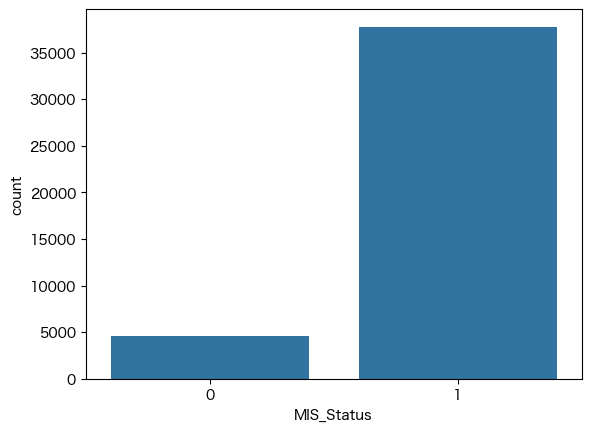

In [21]:
sns.countplot(data=train, x="MIS_Status")

### 前処理 

In [22]:
#Tag
test["kfold"] = -99
train["Tag"] = 1
test["Tag"] = 0

In [23]:
df = pd.concat([train, test])
df.shape

(84615, 22)

In [24]:
df.T.head(50)

,0,1,2,3,4,5,6,7,8,9,...,84605,84606,84607,84608,84609,84610,84611,84612,84613,84614
Term,163,84,242,237,184,60,39,82,57,25,...,60,178,240,7,237,243,178,42,76,35
NoEmp,21,6,45,4,0,7,0,5,6,1,...,5,5,16,3,2,10,0,1,15,3
NewExist,1.0,1.0,1.0,1.0,1.0,1.0,1.0,2.0,2.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,2.0,2.0,1.0,2.0
CreateJob,0,4,4,0,0,4,15,0,0,0,...,0,0,0,14,0,3,0,3,0,1
RetainedJob,0,0,90,0,0,10,1,0,0,0,...,2,0,0,12,0,14,0,9,0,4
FranchiseCode,1,0,0,0,0,0,0,1,0,1,...,1,1,0,0,0,0,1,0,0,18150
RevLineCr,N,0,N,N,N,Y,0,N,N,N,...,N,N,0,N,N,N,N,Y,N,Y
LowDoc,N,N,N,N,N,N,N,C,C,N,...,N,N,N,N,A,N,N,N,N,S
DisbursementDate,31-Jan-98,31-Oct-93,31-Aug-01,31-Aug-07,8-Jun-83,1-Apr-12,8-Nov-11,31-Jan-95,31-Jan-95,30-Apr-07,...,5-Jun-92,31-Jul-95,31-Oct-93,31-May-98,31-Jan-95,1-Dec-12,30-Nov-03,28-Feb-09,31-Jan-08,31-Dec-06
MIS_Status,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [25]:
df.isnull().sum()

Term                     0
NoEmp                    0
NewExist                 0
CreateJob                0
RetainedJob              0
FranchiseCode            0
RevLineCr             2120
LowDoc                1051
DisbursementDate       310
MIS_Status           42308
Sector                   0
ApprovalDate             0
ApprovalFY               0
City                     0
State                    0
BankState               27
DisbursementGross        0
GrAppv                   0
SBA_Appv                 0
UrbanRural               0
kfold                    0
Tag                      0
dtype: int64

In [26]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 84615 entries, 0 to 84614
Data columns (total 22 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Term               84615 non-null  int64  
 1   NoEmp              84615 non-null  int64  
 2   NewExist           84615 non-null  float64
 3   CreateJob          84615 non-null  int64  
 4   RetainedJob        84615 non-null  int64  
 5   FranchiseCode      84615 non-null  int64  
 6   RevLineCr          82495 non-null  object 
 7   LowDoc             83564 non-null  object 
 8   DisbursementDate   84305 non-null  object 
 9   MIS_Status         42307 non-null  float64
 10  Sector             84615 non-null  int64  
 11  ApprovalDate       84615 non-null  object 
 12  ApprovalFY         84615 non-null  int64  
 13  City               84615 non-null  object 
 14  State              84615 non-null  object 
 15  BankState          84588 non-null  object 
 16  DisbursementGross  84615 no

## 設問設定より

In [27]:
## 借り手の会社に関する変数（Sector, FranchiseCode）
## 31-33, 44-45, 48-49 は同じらしい => 32,33を31に, 45を44に, 49を48に変換
#code_dict = {
#    32: 31,
#    33: 31,
#    45: 44,
#    49: 48
#}
#df["Sector"] = df["Sector"].replace(code_dict)

### Time

In [28]:
df[["ApprovalDate","DisbursementDate"]].head()

,ApprovalDate,DisbursementDate
0,22-Sep-06,31-Jan-98
1,30-Jun-92,31-Oct-93
2,18-Apr-01,31-Aug-01
3,6-Oct-03,31-Aug-07
4,17-Dec-99,8-Jun-83


In [29]:
Temp_date_list = df["ApprovalDate"]
s_format = '%d-%b-%y'

date_list = []

for s in Temp_date_list:
    #DateTimeに変換
    dt = datetime.datetime.strptime(s, s_format)
    date_list.append(dt)

df["New_ApprovalDate"] = date_list

In [30]:
# 分解
df["ApprovalDate_Year"] = df["New_ApprovalDate"].dt.year
df["ApprovalDate_Month"] = df["New_ApprovalDate"].dt.month
df["ApprovalDate_Day"] = df["New_ApprovalDate"].dt.day

In [31]:
# 確認用
df[["ApprovalDate","New_ApprovalDate","ApprovalDate_Year","ApprovalDate_Month","ApprovalDate_Day"]].head()

,ApprovalDate,New_ApprovalDate,ApprovalDate_Year,ApprovalDate_Month,ApprovalDate_Day
0,22-Sep-06,2006-09-22,2006,9,22
1,30-Jun-92,1992-06-30,1992,6,30
2,18-Apr-01,2001-04-18,2001,4,18
3,6-Oct-03,2003-10-06,2003,10,6
4,17-Dec-99,1999-12-17,1999,12,17


In [32]:
df[["ApprovalDate","New_ApprovalDate","ApprovalDate_Year","ApprovalDate_Month","ApprovalDate_Day"]].info()

<class 'pandas.core.frame.DataFrame'>
Index: 84615 entries, 0 to 84614
Data columns (total 5 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   ApprovalDate        84615 non-null  object        
 1   New_ApprovalDate    84615 non-null  datetime64[ns]
 2   ApprovalDate_Year   84615 non-null  int32         
 3   ApprovalDate_Month  84615 non-null  int32         
 4   ApprovalDate_Day    84615 non-null  int32         
dtypes: datetime64[ns](1), int32(3), object(1)
memory usage: 4.9+ MB


### "DisbursementDate"には欠損値がある

In [33]:
# 日付系の変数（DisbursementDate, ApprovalDate）
# 日付型へ変更 → 年を抽出（借りた月や日にはあまり意味はないと思われるため）
df['DisbursementDate'] = pd.to_datetime(df['DisbursementDate'], format='%d-%b-%y')
df["Disbursement_Year"] = df["DisbursementDate"].dt.year

In [34]:
df["FY_Diff"] = df["ApprovalFY"] - df["Disbursement_Year"]

In [35]:
df.drop(["DisbursementDate","ApprovalDate","New_ApprovalDate"], axis=1, inplace=True)

## 特徴量作成

In [36]:
# From Kaggle
# https://www.kaggle.com/code/tanmaynema/sba-loan-approval-analysis-prediction

# Category系
df['StateSame'] = np.where(df['State'] == df['BankState'], 1, 0)   # 借り手の会社の所在地（州） == 貸し手の所在地（州）

# 数値系
df['CreateJob_Ratio'] = df['CreateJob'] / (df['NoEmp'] + 1)      # 企業が融資資金を使用して創出すると予想される雇用の数 / 融資を受ける前の事業の従業員数
df['RetainedJob_Ratio'] = df['RetainedJob'] / (df['NoEmp'] + 1)  # 融資を受けたことで企業が維持すると予想される雇用の数 / 融資を受ける前の事業の従業員数
df['SumJob'] = df['CreateJob'] + df['RetainedJob']                # 企業が融資資金を使用して創出すると予想される雇用の数 + 融資を受けたことで企業が維持すると予想される雇用の数

# GrAppv
df['AppvDisbursed'] = np.where(df['DisbursementGross'] == df['GrAppv'], 1, 0)  # 銀行によって支払われた金額  ==  銀行によって承認されたローンの総額
df['SBA_AppvPct'] = df['SBA_Appv'] / df['GrAppv']                              # SBAが保証する承認されたローンの金額 / 銀行によって承認されたローンの総額
df["DisbursementGrossRatio"] = df["DisbursementGross"] / df["GrAppv"]

# Term
df['DisbursementGross_per_Month'] = df['DisbursementGross'] / (df['Term'] + 1)  # 銀行によって支払われた金額 / 融資の期間（月）
df['GrAppv_per_Month'] = df['GrAppv'] / (df['Term'] + 1)                        # 銀行によって承認されたローンの総額 / 融資の期間（月）
df['SBA_Appv_per_Month'] = df['SBA_Appv'] / (df['Term'] + 1)                    # SBAが保証する承認されたローンの金額 / 融資の期間（月）

# NoEmp
df['DisbursementGross_per_Emp'] = df['DisbursementGross'] / (df['NoEmp'] + 1)   # 銀行によって支払われた金額 / 融資を受ける前の事業の従業員数
df['GrAppv_per_Emp'] = df['GrAppv'] / (df['NoEmp'] + 1)                         # 銀行によって承認されたローンの総額 / 融資を受ける前の事業の従業員数
df['SBA_Appv_per_Emp'] = df['SBA_Appv'] / (df['NoEmp'] + 1)                     # SBAが保証する承認されたローンの金額 / 融資を受ける前の事業の従業員数

### 組合せ系

In [37]:
#df["NewExist_and_Sector"] = df['NewExist'].astype(str) + "_" + df['Sector'].astype(str)
#df["NewExist_and_FranchiseCode"] = df['NewExist'].astype(str) + "_" + df['FranchiseCode'].astype(str) 

## Sector

In [38]:
temp_mean = df[["Sector", "DisbursementGross"]].groupby("DisbursementGross").median().reset_index().rename({"Sector":"Sector_MED_DisbursementGross"}, axis=1)
df = df.merge(temp_mean, how = "left", on = "DisbursementGross")

In [39]:
temp_mean = df[["Sector", "GrAppv"]].groupby("GrAppv").median().reset_index().rename({"Sector":"Sector_MED_GrAppv"}, axis=1)
df = df.merge(temp_mean, how = "left", on = "GrAppv")

In [40]:
temp_mean = df[["Sector", "SBA_Appv"]].groupby("SBA_Appv").median().reset_index().rename({"Sector":"Sector_MED_SBA_Appv"}, axis=1)
df = df.merge(temp_mean, how = "left", on = "SBA_Appv")

In [41]:
df['DisbursementGross_per_SectorMED'] = df['DisbursementGross'] / (df['Sector_MED_DisbursementGross'] + 1)
df['GrAppv_per_SectorMED'] = df['GrAppv'] / (df['Sector_MED_GrAppv'] + 1)
df['SBA_Appv_per_SectorMED'] = df['SBA_Appv'] / (df['Sector_MED_SBA_Appv'] + 1)

In [42]:
df.drop(['Sector_MED_DisbursementGross','Sector_MED_GrAppv','Sector_MED_SBA_Appv'],axis=1,inplace=True)

## FranchiseCode

In [43]:
temp_mean = df[["FranchiseCode", "DisbursementGross"]].groupby("DisbursementGross").median().reset_index().rename({"FranchiseCode":"FranchiseCode_MED_DisbursementGross"}, axis=1)
df = df.merge(temp_mean, how = "left", on = "DisbursementGross")

In [44]:
temp_mean = df[["FranchiseCode", "GrAppv"]].groupby("GrAppv").median().reset_index().rename({"FranchiseCode":"FranchiseCode_MED_GrAppv"}, axis=1)
df = df.merge(temp_mean, how = "left", on = "GrAppv")

In [45]:
temp_mean = df[["FranchiseCode", "SBA_Appv"]].groupby("SBA_Appv").median().reset_index().rename({"FranchiseCode":"FranchiseCode_MED_SBA_Appv"}, axis=1)
df = df.merge(temp_mean, how = "left", on = "SBA_Appv")

In [46]:
df['DisbursementGross_per_FranchiseCodeMED'] = df['DisbursementGross'] / (df['FranchiseCode_MED_DisbursementGross'] + 1)
df['GrAppv_per_FranchiseCodeMED'] = df['GrAppv'] / (df['FranchiseCode_MED_GrAppv'] + 1)
df['SBA_Appv_per_FranchiseCodeMED'] = df['SBA_Appv'] / (df['FranchiseCode_MED_SBA_Appv'] + 1)

In [47]:
df.drop(['FranchiseCode_MED_DisbursementGross','FranchiseCode_MED_GrAppv','FranchiseCode_MED_SBA_Appv'],axis=1,inplace=True)

## Category

In [48]:
features = df.drop(["MIS_Status","kfold"],axis=1).columns.to_list()
num_features = [s for s in features if (df[s].dtype=="int") | (df[s].dtype=="float") ]
cat_features = [s for s in features if (df[s].dtype=="object") ]
cat_features

['RevLineCr', 'LowDoc', 'City', 'State', 'BankState']

### Count Encoding

In [49]:
# 文字列を出現回数に変換
for col in cat_features:
    encoder = CountEncoder()
    encoder.fit(df[col])
    df['%s_count'%col] = encoder.transform(df[col])

### Label Encoding

In [50]:
# 文字列を数値に変換
for col in cat_features:
    df[col] = LabelEncoder().fit_transform(df[col])

### TrainとTestに戻す

In [51]:
#data load
train = df[df['Tag']==1]
test = df[df['Tag']==0]

In [52]:
train = train.drop('Tag',axis=1)
test = test.drop('Tag',axis=1)
train.shape, test.shape

((42307, 48), (42308, 48))

In [53]:
train['id'] = train.index

In [54]:
train.T.head(50)

,0,1,2,3,4,5,6,7,8,9,...,42297,42298,42299,42300,42301,42302,42303,42304,42305,42306
Term,163.000000,84.000000,242.000000,237.000000,184.000000,60.000000,39.000000,82.000000,57.000000,25.000000,...,57.000000,82.000000,10.000000,82.000000,82.000000,283.000000,53.000000,59.000000,295.000000,84.000000
NoEmp,21.000000,6.000000,45.000000,4.000000,0.000000,7.000000,0.000000,5.000000,6.000000,1.000000,...,2.000000,15.000000,2.000000,3.000000,0.000000,14.000000,2.000000,6.000000,18.000000,4.000000
NewExist,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,2.000000,2.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,2.000000,1.000000,1.000000
CreateJob,0.000000,4.000000,4.000000,0.000000,0.000000,4.000000,15.000000,0.000000,0.000000,0.000000,...,0.000000,1.000000,0.000000,0.000000,18.000000,0.000000,0.000000,0.000000,0.000000,0.000000
RetainedJob,0.000000,0.000000,90.000000,0.000000,0.000000,10.000000,1.000000,0.000000,0.000000,0.000000,...,0.000000,10.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,8.000000,8.000000
FranchiseCode,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,...,960.000000,72590.000000,0.000000,1.000000,1.000000,1.000000,0.000000,1.000000,0.000000,0.000000
RevLineCr,1.000000,0.000000,1.000000,1.000000,1.000000,3.000000,0.000000,1.000000,1.000000,1.000000,...,1.000000,0.000000,3.000000,1.000000,3.000000,1.000000,3.000000,1.000000,1.000000,1.000000
LowDoc,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,2.000000,2.000000,3.000000,...,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000
MIS_Status,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
Sector,0.000000,62.000000,42.000000,33.000000,0.000000,44.000000,23.000000,0.000000,61.000000,0.000000,...,0.000000,44.000000,72.000000,42.000000,23.000000,0.000000,42.000000,42.000000,42.000000,72.000000


### 学習

In [55]:
useful_features = [c for c in train.columns if c not in ("id","MIS_Status","kfold")]
useful_features

['Term',
 'NoEmp',
 'NewExist',
 'CreateJob',
 'RetainedJob',
 'FranchiseCode',
 'RevLineCr',
 'LowDoc',
 'Sector',
 'ApprovalFY',
 'City',
 'State',
 'BankState',
 'DisbursementGross',
 'GrAppv',
 'SBA_Appv',
 'UrbanRural',
 'ApprovalDate_Year',
 'ApprovalDate_Month',
 'ApprovalDate_Day',
 'Disbursement_Year',
 'FY_Diff',
 'StateSame',
 'CreateJob_Ratio',
 'RetainedJob_Ratio',
 'SumJob',
 'AppvDisbursed',
 'SBA_AppvPct',
 'DisbursementGrossRatio',
 'DisbursementGross_per_Month',
 'GrAppv_per_Month',
 'SBA_Appv_per_Month',
 'DisbursementGross_per_Emp',
 'GrAppv_per_Emp',
 'SBA_Appv_per_Emp',
 'DisbursementGross_per_SectorMED',
 'GrAppv_per_SectorMED',
 'SBA_Appv_per_SectorMED',
 'DisbursementGross_per_FranchiseCodeMED',
 'GrAppv_per_FranchiseCodeMED',
 'SBA_Appv_per_FranchiseCodeMED',
 'RevLineCr_count',
 'LowDoc_count',
 'City_count',
 'State_count',
 'BankState_count']

### Metric

In [56]:
# 2値専用
def f1(y_pred, data):
    y_true = data.get_label()
    score = f1_score(np.round(y_pred), y_true, average='macro')
    return 'custom', score, True

### Params

In [57]:
# LGBMのパラメータを設定
param = {
    'device_type': 'CPU',
    'num_threads': 4,
    'task': 'train',
    'boosting_type': 'gbdt',
    'objective': 'binary',
    'metric': 'custom',
    'learning_rate': 0.01,
    'verbosity': -1,
    'bagging_seed': SEED,
    'feature_fraction_seed': SEED,
    'seed': SEED,
    'feature_pre_filter': False,
    'lambda_l1': 0.00019003067558908974,
    'lambda_l2': 1.0666541081367144e-06,
    'num_leaves': 250,
    'feature_fraction': 0.8733106659442259,
    'bagging_fraction': 0.6587325310514013,
    'min_child_samples': 38
}

In [58]:
test_predictions = []
valid_predictions = {}
scores = []

for fold in range(FOLD):

    xtrain = train[train.kfold != fold].reset_index(drop=True)
    xvalid = train[train.kfold == fold].reset_index(drop=True)
    xtest = test[useful_features]

    # For Stacking
    valid_ids = xvalid.id.values.tolist()

    ytrain = xtrain.MIS_Status
    yvalid = xvalid.MIS_Status
    
    xtrain = xtrain[useful_features]
    xvalid = xvalid[useful_features]

    # 不均衡データ対策
    lgb_train = lgb.Dataset(xtrain, ytrain,
                             weight = compute_sample_weight(class_weight='balanced',y=ytrain).astype('float32'))
    
    lgb_valid = lgb.Dataset(xvalid, yvalid)
    
    model = lgb.train(param,
                      lgb_train,
                      valid_names=['train', 'valid'],
                      valid_sets=[lgb_train, lgb_valid],
                      feval=f1,
                      #categorical_feature = cat_features, #ここでcategorical_featureを設定
                      num_boost_round=50000,
                      callbacks=[lgb.early_stopping(stopping_rounds=100, verbose=True), lgb.log_evaluation(500)]
                      )
    
    # For Validation
    valid_pred = model.predict(xvalid,num_iteration=model.best_iteration)
    valid_predictions.update(dict(zip(valid_ids, valid_pred)))

    ###########
    # 推論部分 #
    ##########    
    # For Test
    test_preds = model.predict(xtest,num_iteration=model.best_iteration)
    test_predictions.append(test_preds)

    ##############
    # F1を計算する #
    ##############
    # テストデータの予測 (予測クラス(0 or 1)を返す)
    valids_pred = np.where(valid_pred <= 0.5, 0, 1) # 0.5より小さい場合0 ,そうでない場合1を返す
    score = f1_score(yvalid, valids_pred, average='macro')
    print(f'fold {fold} F1: {score}')
    scores.append(score)

    #print(model.params)

print(np.mean(scores), np.std(scores))

# For Blending and Stacking
final_valid_predictions = pd.DataFrame.from_dict(valid_predictions, orient="index").reset_index()
final_valid_predictions.columns = ["id", "LGBM_pred"]
final_valid_predictions.to_csv("train_LGBM_20240128_pred.csv", index=False)
#
final_test_predictions = np.average(test_predictions, axis = 0)
sample_submission['LGBM_pred'] = final_test_predictions
sample_submission.to_csv("test_LGBM_20240128_pred.csv",index=False)

Training until validation scores don't improve for 100 rounds
[500]	train's custom: 0.88779	valid's custom: 0.665573
[1000]	train's custom: 0.947926	valid's custom: 0.680813
Early stopping, best iteration is:
[923]	train's custom: 0.941585	valid's custom: 0.682822
fold 0 F1: 0.682822253047626
Training until validation scores don't improve for 100 rounds
[500]	train's custom: 0.88583	valid's custom: 0.658452
Early stopping, best iteration is:
[883]	train's custom: 0.938759	valid's custom: 0.668499
fold 1 F1: 0.6684992667234364
Training until validation scores don't improve for 100 rounds
[500]	train's custom: 0.884899	valid's custom: 0.666779
Early stopping, best iteration is:
[816]	train's custom: 0.930367	valid's custom: 0.679498
fold 2 F1: 0.6794976585314119
Training until validation scores don't improve for 100 rounds
[500]	train's custom: 0.889694	valid's custom: 0.667485
Early stopping, best iteration is:
[827]	train's custom: 0.93458	valid's custom: 0.671446
fold 3 F1: 0.67144647

### cv:0.6728910211898987
### LB:0.6779034

### 解析

<Axes: title={'center': 'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

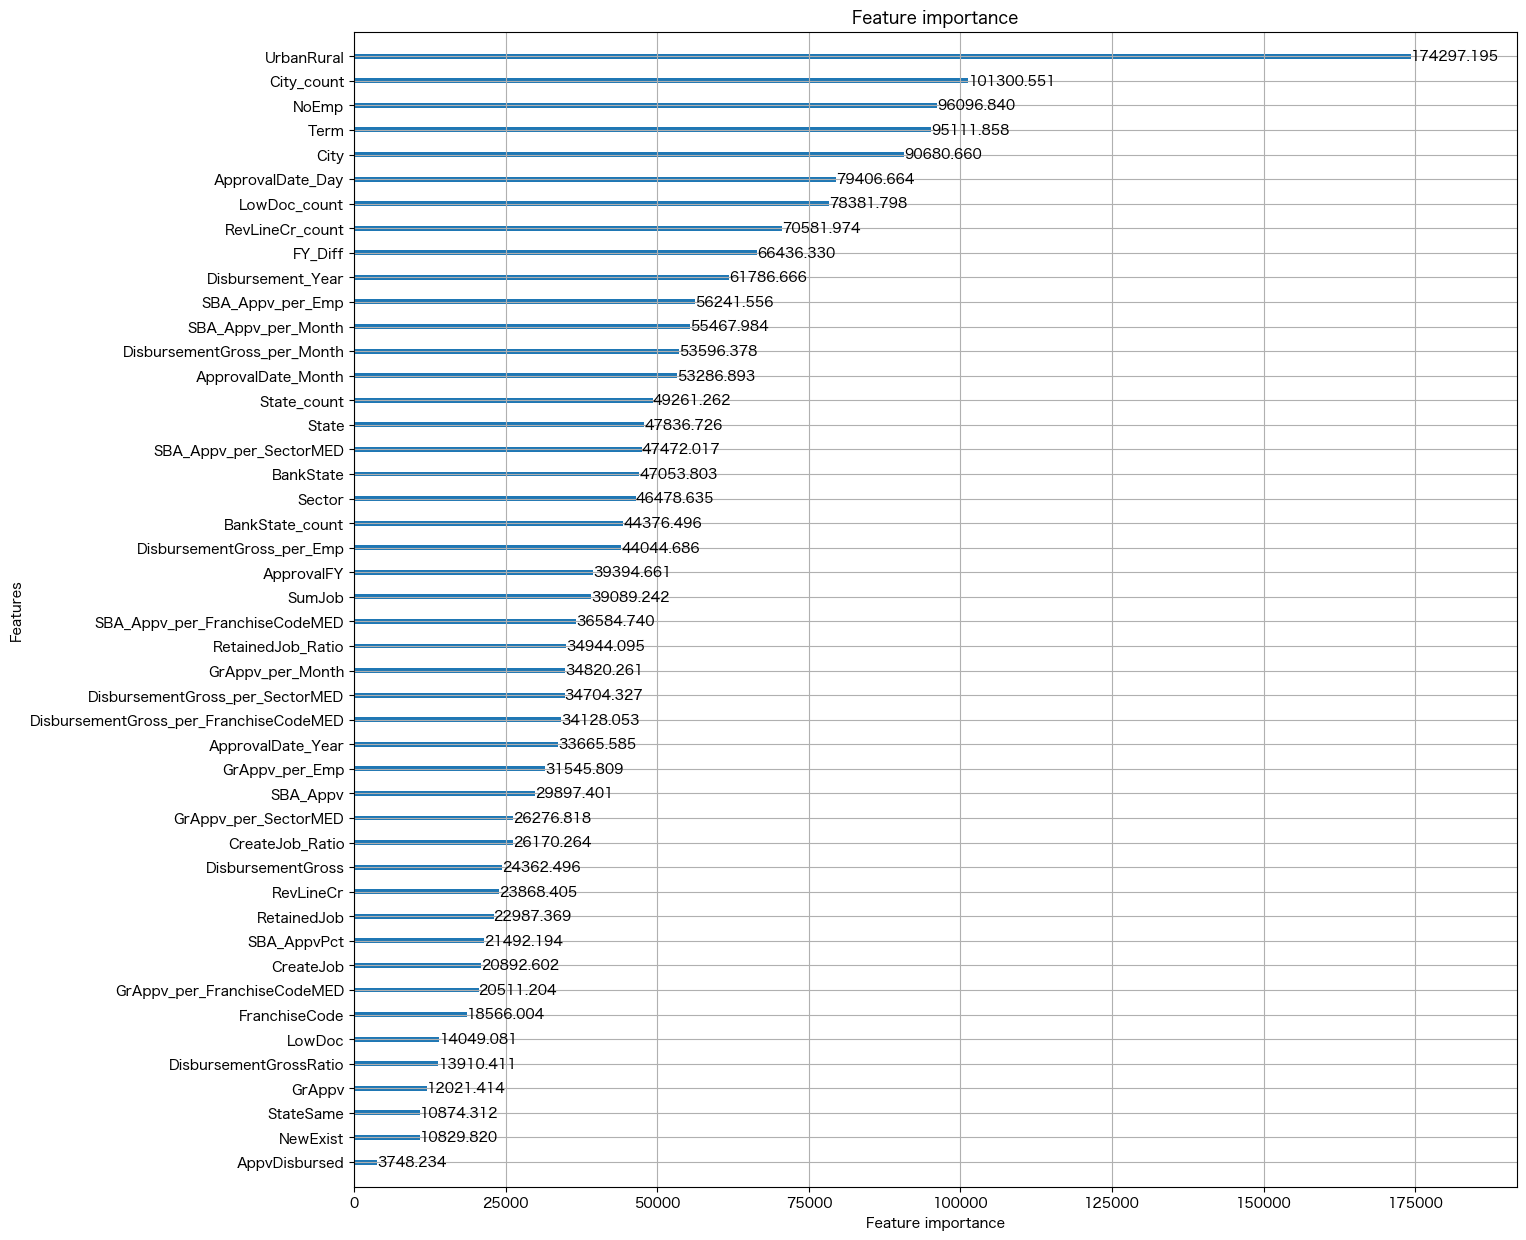

In [59]:
lgb.plot_importance(model,figsize=(15,15), max_num_features=50, importance_type='gain')

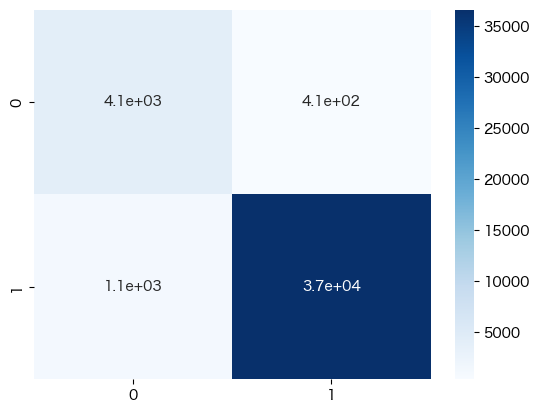

In [60]:
# confusion　matrix
train_pred = model.predict(train[useful_features], num_iteration=model.best_iteration)

# テストデータの予測 (予測クラス(0 or 1)を返す)
train_pred = np.where(train_pred <= 0.5, 0, 1) # 0.5より小さい場合0 ,そうでない場合1を返す

cm = confusion_matrix(train['MIS_Status'],train_pred)
sns.heatmap(cm, annot=True, cmap='Blues')
plt.show()

### F1スコアの閾値を最適化する

In [61]:
#def find_optimal_threshold(y_true, y_scores):
#    thresholds = np.linspace(0, 1, 100)
#    best_threshold = 0
#    best_score = 0
#
#    for threshold in thresholds:
#        y_pred = (y_scores > threshold).astype(int)
#        score = f1_score(y_true, y_pred, average='macro')
#
#        if score > best_score:
#            best_score = score
#            best_threshold = threshold
#
#    return best_threshold, best_score

In [62]:
#y_true = train['MIS_Status'].values # 正解のラベル
#train_pred = model.predict(train[useful_features], num_iteration=model.best_iteration)
#y_scores = train_pred # oof_predictionの予測値（0~1までの確率値）
#
#best_threshold, best_f1_score = find_optimal_threshold(y_true, y_scores)
#print(f"Best threshold: {best_threshold}") # 最適な閾値
#print(f"Best F1 Score: {best_f1_score}") # 最適な閾値でのF1スコア

In [63]:
## テストデータの予測 (予測クラス(0 or 1)を返す)
#train_preds = np.where(train_pred <= best_threshold, 0, 1) # best_thresholdより小さい場合0 ,そうでない場合1を返す
#cm = confusion_matrix(train['MIS_Status'], train_preds)
#sns.heatmap(cm, annot=True, cmap='Blues')
#plt.show()

### 提出

In [64]:
sample_submission.head()

,LGBM_pred
id,
42307,0.115133
42308,0.971563
42309,0.341242
42310,0.682727
42311,0.945497


In [65]:
test_predictions

[array([0.15040881, 0.9706227 , 0.28811463, ..., 0.88060592, 0.75557404,
        0.0666068 ]),
 array([0.10673539, 0.97442318, 0.35170519, ..., 0.72646027, 0.90383401,
        0.07124238]),
 array([0.11599093, 0.9817263 , 0.48268703, ..., 0.83130178, 0.70648865,
        0.08337726]),
 array([0.16308435, 0.95218357, 0.35532086, ..., 0.74270895, 0.67108545,
        0.04870571]),
 array([0.07480614, 0.94637918, 0.26358111, ..., 0.73750397, 0.48021437,
        0.06123984]),
 array([0.10099959, 0.98565991, 0.46037564, ..., 0.80674333, 0.75052481,
        0.07186599]),
 array([0.09390333, 0.9899451 , 0.18690768, ..., 0.80207062, 0.63623372,
        0.05243766])]

In [66]:
final_test_predictions = np.average(test_predictions, axis = 0)
final_test_predictions

array([0.11513265, 0.97156285, 0.34124173, ..., 0.78962783, 0.70056501,
       0.06506795])

In [67]:
# テストデータの予測 (予測クラス(0 or 1)を返す)
pred = np.where(final_test_predictions <= 0.5, 0, 1) # best_thresholdより小さい場合0 ,そうでない場合1を返す

In [68]:
sample_submission['LGBM_pred'] = pred
sample_submission.head()

,LGBM_pred
id,
42307,0
42308,1
42309,0
42310,1
42311,1


In [69]:
#sample_submission.to_csv('submit_0128_3rd.csv', header=None)